In [2]:
import numpy as np

def RandomBinaryBitGenerator(numBits):
    return np.random.randint(0, 2, numBits)

In [3]:
def QAMmodulator(bits, M):
    #심볼 당 필요한 비트 수
    k = int(np.log2(M))
    # 비트 그룹화
    bitGroups = bits.reshape((-1, k))

    if M == 4:
        # QPSK 변조
        A = 1/np.sqrt(2)
        Q = np.zeros(len(bitGroups)) #실수축
        I = np.zeros(len(bitGroups)) #허수축
        
        for i, bit in enumerate(bitGroups):
            #실수축 매핑
            if bit[0] == 0:
                Q[i] = 1
            elif bit[0] == 1:
                Q[i] = -1
            
            #허수축 매핑
            if bit[1] == 0:
                I[i] = 1
            elif bit[1] == 1:
                I[i] = -1
        
        Q *= A
        I *= A
            
        symbols = Q + 1j * I
            
    elif M == 16:
        # 16QAM 변조
        A = 1/np.sqrt(10)
        Q = np.zeros(len(bitGroups)) #실수축
        I = np.zeros(len(bitGroups)) #허수축
        
        for i, bit in enumerate(bitGroups):
            #실수축 매핑
            if np.array_equal(bit[:2], [0, 0]):
                Q[i] = 3
            elif np.array_equal(bit[:2], [0, 1]):
                Q[i] = 1
            elif np.array_equal(bit[:2], [1, 1]):
                Q[i] = -1
            elif np.array_equal(bit[:2], [1, 0]):
                Q[i] = -3
            
            # 허수축 매핑
            if np.array_equal(bit[2:], [0, 0]):
                I[i] = 3
            elif np.array_equal(bit[2:], [0, 1]):
                I[i] = 1
            elif np.array_equal(bit[2:], [1, 1]):
                I[i] = -1
            elif np.array_equal(bit[2:], [1, 0]):
                I[i] = -3
        
        Q *= A
        I *= A
            
        symbols = Q + 1j * I
    
    return symbols

In [4]:
def ChannelModel(tranSymbols, channelType, SNR_linear):
    #가우시안 노이즈 평균 0, 분산 0.5 고정
    noise_power = np.sqrt(0.5 / SNR_linear)  #노이즈 전력
    noise = noise_power * np.sqrt(0.5) * (np.random.randn(*tranSymbols.shape) + 1j * np.random.randn(*tranSymbols.shape))
    if channelType == "AWGN":
        receivedSymbols = tranSymbols + noise
    elif channelType == "Rayleigh":
        #Rayleigh Fading coefficient 평균 0, 분산 0.5 고정
        h_real = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        h_img = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        
        h = h_real + 1j * h_img #fading 계수
        h_norm = np.abs(h)
        
        receivedSymbols = h_norm * tranSymbols + noise
    
    return receivedSymbols

In [5]:
def QAMdemodulator(receivedSymbols, M):
    k = int(np.log2(M)) #심볼당 필요한 비트 수
    bits = np.zeros((len(receivedSymbols), k), dtype=int)
    
    if M == 4:
        # QPSK 복조
        A = 1/np.sqrt(2)
        Q = np.real(receivedSymbols) / A #실수부 추출
        I = np.imag(receivedSymbols) / A #허수부 추출

        bits[:, 0] = Q < 0  #첫번째 비트: 실수부 값이 음수면 1
        bits[:, 1] = I < 0  #두번째 비트: 허수부 값이 음수면 1

        bits = bits.flatten()
    
    elif M == 16:
        #16QAM 복조
        A = 1/np.sqrt(10)
        Q = np.real(receivedSymbols) / A #실수부 추출
        I = np.imag(receivedSymbols) / A #허수부 추출
        
        bits[:, 0] = Q < 0 #첫번째 비트: 실수부 값이 음수면 1
        bits[:, 1] = np.abs(Q) < 2 #두번째 비트: 실수부 절대 값이 2보다 작으면 1
        bits[:, 2] = I < 0 #세번째 비트: 허수부 값이 음수면 1
        bits[:, 3] = np.abs(I) < 2 #네번째 비트: 허수부 절대 값이 2보다 작으면 1
        bits = bits.flatten()
    
    return bits

In [6]:
def ErrorCounter(transBits, receivedBits, M):
    k = int(np.log2(M))
    
    transSymbols = transBits.reshape((-1, k))
    receivedSymbols = receivedBits.reshape((-1, k))
    
    symbolErrors = np.sum(np.any(transSymbols != receivedSymbols, axis=1))
    totalSymbols = transSymbols.shape[0]
    
    # Symbol Error Rate 계산
    SER = symbolErrors / totalSymbols
    
    return SER

In [7]:
import matplotlib.pyplot as plt
import scipy.special as sp

def qfunc(x):
    return 0.5 * sp.erfc(x / np.sqrt(2))

In [8]:
def ChannelModel_MRC(tranSymbols, SNR_linear, num_paths=2):
    #가우시안 노이즈 평균 0, 분산 0.5 고정
    noise_power = np.sqrt(0.5 / SNR_linear)  #노이즈 전력
    
    symbol_num = len(tranSymbols)
    received_signals = np.zeros((num_paths, symbol_num), dtype=complex)
    channel_coeffs = np.zeros((num_paths, symbol_num), dtype=complex)
    for path in range(num_paths):
        #Rayleigh Fading coefficient 평균 0, 분산 0.5 고정
        h_real = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        h_img = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        
        h = h_real + 1j * h_img #fading 계수
        h_norm = np.abs(h)
        channel_coeffs[path, :] = h_norm
        
        noise = noise_power * np.sqrt(0.5) * (np.random.randn(*tranSymbols.shape) + 1j * np.random.randn(*tranSymbols.shape))
        
        received_signals[path, :] = h_norm * tranSymbols + noise
    
    return received_signals, channel_coeffs

def MRC(received_signals, channel_coeffs):
    combined_signal = np.sum(np.conj(channel_coeffs) * received_signals, axis=0)
    #정규화
    combined_signal /= np.sum(np.abs(channel_coeffs)**2, axis=0)
    
    return combined_signal

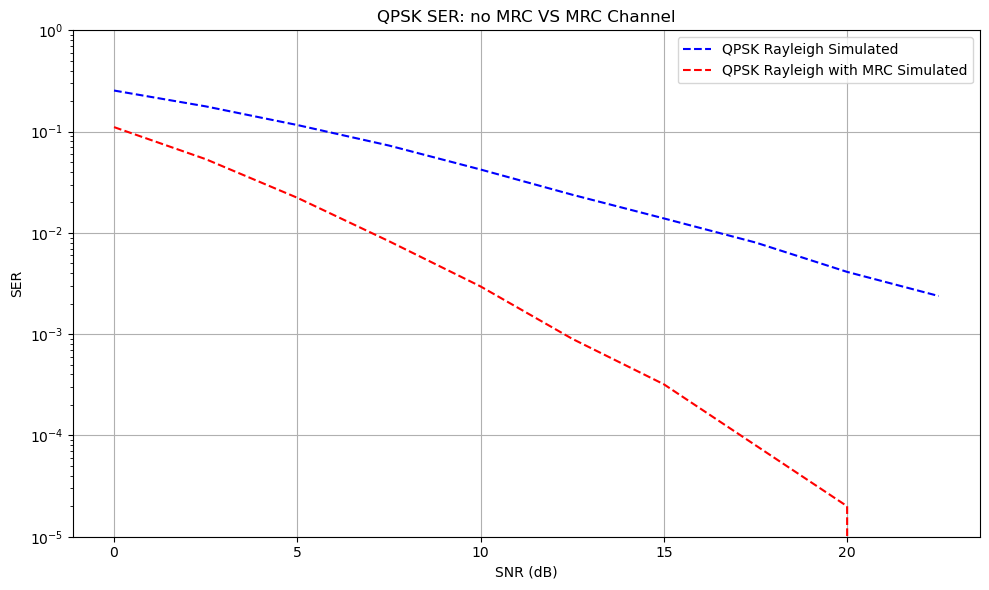

In [9]:
#Recall - MRC gain

SNR_dB_range = np.arange(0, 25, 2.5)
SNR_linear = 10**(SNR_dB_range / 10)

bits = RandomBinaryBitGenerator(100000)
SER_qpsk = np.zeros(len(SNR_dB_range))
SER_qpsk_MRC = np.zeros(len(SNR_dB_range))

for idx, snr_db in enumerate(SNR_dB_range):
    #QAM modulate
    symbol_qpsk = QAMmodulator(bits, 4)

    #수신
    received_qpsk = ChannelModel(symbol_qpsk, "Rayleigh", SNR_linear[idx])
    channel_2_qpsk, channel_2_coeffs_qpsk = ChannelModel_MRC(symbol_qpsk, SNR_linear[idx])
    combined_qpsk = MRC(channel_2_qpsk, channel_2_coeffs_qpsk)
    
    #QAM demodulate
    received_bits_qpsk = QAMdemodulator(received_qpsk, 4)
    received_bits_qpsk_mrc = QAMdemodulator(combined_qpsk, 4)

    #SER 계산
    SER_qpsk[idx] = ErrorCounter(bits, received_bits_qpsk, 4)
    SER_qpsk_MRC[idx] = ErrorCounter(bits, received_bits_qpsk_mrc, 4)

# 그래프 그리기
plt.figure(figsize=(10, 6))
    
# QPSK 시뮬레이션 결과와 이론적 결과
plt.semilogy(SNR_dB_range, SER_qpsk, 'b--', label="QPSK Rayleigh Simulated")
plt.semilogy(SNR_dB_range, SER_qpsk_MRC, 'r--', label="QPSK Rayleigh with MRC Simulated")
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('QPSK SER: no MRC VS MRC Channel')
plt.legend()
plt.grid(True)
plt.ylim(1e-5, 10**0)  # y축 범위 설정

plt.tight_layout()
plt.show()

In [10]:
# Alamouti Scheme
def AlamoutiScheme(symbols, SNR_linear):
    s1 = symbols[0]
    s2 = symbols[1]

    # Rayleigh Fading 채널 계수 생성
    h1 = np.sqrt(0.5) * (np.random.randn() + 1j * np.random.randn())
    h2 = np.sqrt(0.5) * (np.random.randn() + 1j * np.random.randn())
    
    # 노이즈 추가 (SNR에 따른 조정)
    noise_power = np.sqrt(0.5 / SNR_linear)
    noise_y1 = noise_power * (np.random.randn() + 1j * np.random.randn())
    noise_y2 = noise_power * (np.random.randn() + 1j * np.random.randn())
    
    # Alamouti 스킴의 두 송신 신호 생성
    y1 = h1 * s1 + h2 * s2 + noise_y1
    y2 = h1 * (-np.conj(s2)) + h2 * np.conj(s1) + noise_y2
    
    return y1, y2, h1, h2

# Alamouti Receiver
def AlamoutiReceiver(y1, y2, h1, h2):
    s1_hat = np.conj(h1) * y1 + h2 * np.conj(y2)
    s1_hat /= (np.abs(h1)**2 + np.abs(h2)**2)  # 정규화
    s2_hat = np.conj(h2) * y1 - h1 * np.conj(y2)
    s2_hat /= (np.abs(h1)**2 + np.abs(h2)**2)  # 정규화
    
    return s1_hat, s2_hat

In [11]:
# Alamouti 스킴 (송신 안테나 2개, 수신 안테나 2개)
def AlamoutiScheme_MRC(symbols, SNR_linear):
    s1 = symbols[0]
    s2 = symbols[1]

    # Rayleigh Fading 채널 계수 생성 (수신 안테나 2개)
    h1_1 = np.sqrt(0.5) * (np.random.randn() + 1j * np.random.randn())  # 수신 안테나 1에 대한 h1
    h1_2 = np.sqrt(0.5) * (np.random.randn() + 1j * np.random.randn())  # 수신 안테나 2에 대한 h1
    h2_1 = np.sqrt(0.5) * (np.random.randn() + 1j * np.random.randn())  # 수신 안테나 1에 대한 h2
    h2_2 = np.sqrt(0.5) * (np.random.randn() + 1j * np.random.randn())  # 수신 안테나 2에 대한 h2

    # 노이즈 추가 (SNR에 따른 조정)
    noise_power = np.sqrt(0.5 / SNR_linear)
    noise_y1_1 = noise_power * (np.random.randn() + 1j * np.random.randn())
    noise_y1_2 = noise_power * (np.random.randn() + 1j * np.random.randn())
    noise_y2_1 = noise_power * (np.random.randn() + 1j * np.random.randn())
    noise_y2_2 = noise_power * (np.random.randn() + 1j * np.random.randn())

    # Alamouti 스킴의 수신 안테나 1과 수신 안테나 2에서 받은 신호 생성
    #y1
    y1_1 = h1_1 * s1 + h2_1 * s2 + noise_y1_1  # 수신 안테나 1의 y1
    y1_2 = h1_2 * s1 + h2_2 * s2 + noise_y1_2  # 수신 안테나 2의 y1
    #y2
    y2_1 = h1_1 * (-np.conj(s2)) + h2_1 * np.conj(s1) + noise_y2_1  # 수신 안테나 1의 y2
    y2_2 = h1_2 * (-np.conj(s2)) + h2_2 * np.conj(s1) + noise_y2_2  # 수신 안테나 2의 y2

    return (y1_1, y1_2), (y2_1, y2_2), (h1_1, h1_2), (h2_1, h2_2)

# Alamouti Receiver with MRC 적용
def AlamoutiReceiver_MRC(y1, y2, h1, h2):
    # s1 추정값 계산
    s1_hat = np.conj(h1[0]) * y1[0] + h2[0] * np.conj(y2[0]) + np.conj(h1[1]) * y1[1] + h2[1] * np.conj(y2[1])
    s1_hat /= (np.abs(h1[0])**2 + np.abs(h2[0])**2 + np.abs(h1[1])**2 + np.abs(h2[1])**2)  # 정규화

    # s2 추정값 계산
    s2_hat = np.conj(h2[0]) * y1[0] - h1[0] * np.conj(y2[0]) + np.conj(h2[1]) * y1[1] - h1[1] * np.conj(y2[1])
    s2_hat /= (np.abs(h1[0])**2 + np.abs(h2[0])**2 + np.abs(h1[1])**2 + np.abs(h2[1])**2)  # 정규화

    return s1_hat, s2_hat

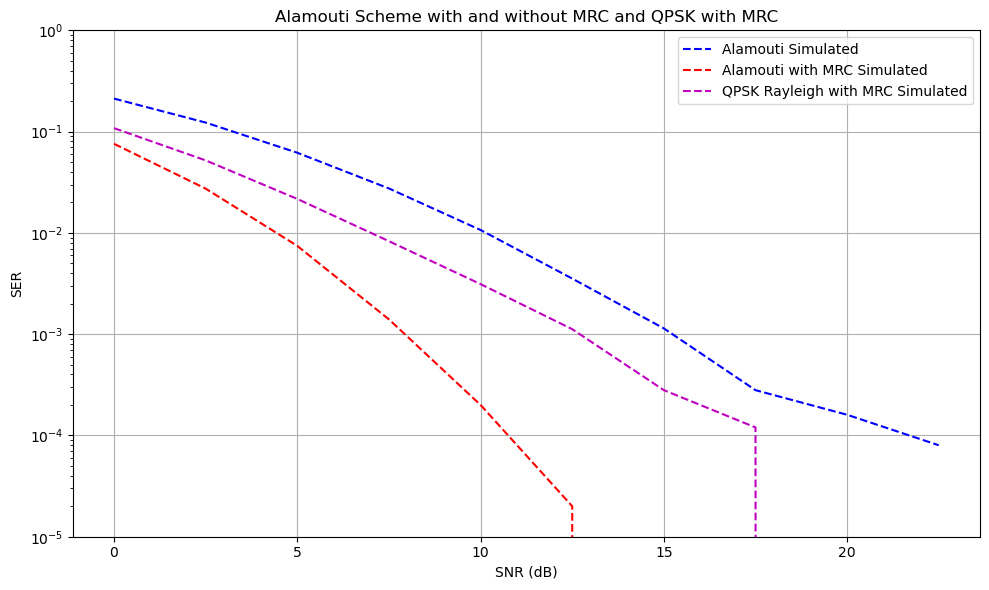

In [12]:
#Problem 1 - Alamouti Scheme
SNR_dB_range = np.arange(0, 25, 2.5)
SNR_linear = 10**(SNR_dB_range / 10)

bits = RandomBinaryBitGenerator(100000)
num_symbols = len(bits) // 2  # 두 개 심볼씩 전송
SER_alamouti = np.zeros(len(SNR_dB_range))
SER_alamouti_MRC = np.zeros(len(SNR_dB_range))

for idx, snr_db in enumerate(SNR_dB_range):
    received_bits_alamouti = np.zeros_like(bits)  # 복원된 비트 저장용 배열
    received_bits_alamouti_MRC = np.zeros_like(bits)
    
    for i in range(0, len(bits), 2 * int(np.log2(4))):  # QPSK 변조: M=4
        # 두 심볼을 Alamouti 방식으로 전송
        symbol_pair = QAMmodulator(bits[i:i+2*int(np.log2(4))], 4)
        
        # Alamouti 적용
        y1, y2, h1, h2 = AlamoutiScheme(symbols=symbol_pair, SNR_linear=SNR_linear[idx])
        s1_hat, s2_hat = AlamoutiReceiver(y1, y2, h1, h2)
        
        # 복원된 심볼을 비트로 변환하여 저장
        received_symbols = [s1_hat, s2_hat]
        received_bits_alamouti[i:i+2*int(np.log2(4))] = QAMdemodulator(received_symbols, 4)

        # Alamouti + MRC 적용
        y1, y2, h1, h2 = AlamoutiScheme_MRC(symbol_pair, SNR_linear[idx])
        
        # 두 경로에서 수신된 신호를 MRC로 결합
        s1_hat_mrc, s2_hat_mrc = AlamoutiReceiver_MRC(y1, y2, h1, h2)
        
        # 각각의 결합된 신호에 대해 복조
        received_bits_combined_s1 = QAMdemodulator([s1_hat_mrc], 4)
        received_bits_combined_s2 = QAMdemodulator([s2_hat_mrc], 4)
        
        # 결합된 신호에서 복원한 비트를 저장 (s1과 s2 각각 복조 후 병합)
        received_bits_alamouti_MRC[i:i+2*int(np.log2(4))] = np.concatenate((received_bits_combined_s1, received_bits_combined_s2))
    
    
    # SER 계산
    SER_alamouti[idx] = ErrorCounter(bits, received_bits_alamouti, 4)
    SER_alamouti_MRC[idx] = ErrorCounter(bits, received_bits_alamouti_MRC, 4)

# QPSK with MRC Simulation
SER_qpsk_MRC = np.zeros(len(SNR_dB_range))

for idx, snr_db in enumerate(SNR_dB_range):
    # QAM modulate
    symbol_qpsk = QAMmodulator(bits, 4)
    
    # QPSK + MRC 채널
    channel_2_qpsk, channel_2_coeffs_qpsk = ChannelModel_MRC(symbol_qpsk, SNR_linear[idx])
    combined_qpsk = MRC(channel_2_qpsk, channel_2_coeffs_qpsk)
    
    # QAM demodulate
    received_bits_qpsk_mrc = QAMdemodulator(combined_qpsk, 4)

    # SER 계산
    SER_qpsk_MRC[idx] = ErrorCounter(bits, received_bits_qpsk_mrc, 4)


# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.semilogy(SNR_dB_range, SER_alamouti, 'b--', label="Alamouti Simulated")
plt.semilogy(SNR_dB_range, SER_alamouti_MRC, 'r--', label="Alamouti with MRC Simulated")
plt.semilogy(SNR_dB_range, SER_qpsk_MRC, 'm--', label="QPSK Rayleigh with MRC Simulated")
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('Alamouti Scheme with and without MRC and QPSK with MRC')
plt.legend()
plt.grid(True)
plt.ylim(1e-5, 10**0)  # y축 범위 설정
plt.tight_layout()
plt.show()

In [22]:
#Problem 2 MIMO channel: CSI at Both Tx and Rx
# Channel Matrix H
H = np.array([[1, 2, 0],
              [2, 1, 0],
              [0, 0, 2]])

# Number of bits and SNR range
num_bits = 3 * 4000000  # 3 streams
# Generate random bits
bits = RandomBinaryBitGenerator(num_bits)
tx_symbols = QAMmodulator(bits, 4).reshape(3, -1) * np.sqrt(10)

# SVD decomposition to find parallel channels
U, S, Vh = np.linalg.svd(H)
V = Vh.conj().T
U_t = U.conj().T
parallel_channels = S  # h_i values for each parallel channel

# Print h_i values for each channel as required in part (a)
print(f"Parallel channel gains (h_i): {parallel_channels}")

# Noise variance for calculation
noise_variance = 1
noise = np.zeros_like(tx_symbols, dtype=complex)

# Initialize SER array
SER_streams = np.zeros(3)
SNR_channels = (10 * (parallel_channels ** 2)) / (noise_variance ** 2)
print("각 채널별 SNR:", SNR_channels)
# Calculate SER for each stream
SER_theory_channels = [1 - (1 - qfunc(np.sqrt(snr)))**2 for snr in SNR_channels]

# Transmit symbols through V matrix and add noise to each channel
X = V @ tx_symbols
Rx = H @ X
# Generate noise for each channel
noise_variance = 1
noise1 = (np.random.randn(tx_symbols.shape[1]) + 1j * np.random.randn(tx_symbols.shape[1])) * np.sqrt(noise_variance / 2)
noise2 = (np.random.randn(tx_symbols.shape[1]) + 1j * np.random.randn(tx_symbols.shape[1])) * np.sqrt(noise_variance / 2)
noise3 = (np.random.randn(tx_symbols.shape[1]) + 1j * np.random.randn(tx_symbols.shape[1])) * np.sqrt(noise_variance / 2)
MIMO_noise= np.array([noise1, noise2, noise3])
y = Rx + MIMO_noise
yt = U_t @ y

# 채널별로 비트를 구분하기 위해 reshaped_bits 배열 생성
reshaped_bits = bits.reshape(3, -1)

for i in range(3):
    channel_bits = reshaped_bits[i]
    received_bits = QAMdemodulator(yt[i, :], 4)
    SER_streams[i] = ErrorCounter(channel_bits, received_bits, 4)

for i, ser in enumerate(SER_theory_channels):
    print(f"SER(theory) for channel {i + 1}: {ser:.10f}")
    
# Print the SER values for each stream
for i in range(3):
    print(f"SER(Errorcounter) for channel {i+1}: {SER_streams[i]:.10f}")

Parallel channel gains (h_i): [3. 2. 1.]
각 채널별 SNR: [90. 40. 10.]
SER(theory) for channel 1: 0.0000000000
SER(theory) for channel 2: 0.0000000003
SER(theory) for channel 3: 0.0015647896
SER(Errorcounter) for channel 1: 0.0000000000
SER(Errorcounter) for channel 2: 0.0000000000
SER(Errorcounter) for channel 3: 0.0015660000
